In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 30)
sns.set_style('whitegrid')

!pip install lifelines
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import survival_table_from_events
from lifelines.statistics import (logrank_test, 
                                  pairwise_logrank_test, 
                                  multivariate_logrank_test, 
                                  survival_difference_at_fixed_point_in_time_test)
from lifelines import CoxPHFitter, CoxTimeVaryingFitter
from lifelines.statistics import proportional_hazard_test


     |████████████████████████████████| 348kB 6.7MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp36-none-any.whl size=4035 sha256=d608c6e6004fdb42234647498f32bdc0e71145164bcc02816441838ced12bfc1
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/WojciechPiaskowski/heart_failure_prediction/master/heart_failure_clinical_records_dataset.csv', sep=',', header=0)

In [3]:
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000,299.000,299.000,299.000,299.000,299.000,299.000,299.000,299.000,299.000,299.000,299.000,299.000
mean,60.834,0.431,581.839,0.418,38.084,0.351,263358.029,1.394,136.625,0.649,0.321,130.261,0.321
std,11.895,0.496,970.288,0.494,11.835,0.478,97804.237,1.035,4.412,0.478,0.468,77.614,0.468
min,40.000,0.000,23.000,0.000,14.000,0.000,25100.000,0.500,113.000,0.000,0.000,4.000,0.000
25%,51.000,0.000,116.500,0.000,30.000,0.000,212500.000,0.900,134.000,0.000,0.000,73.000,0.000
50%,60.000,0.000,250.000,0.000,38.000,0.000,262000.000,1.100,137.000,1.000,0.000,115.000,0.000
75%,70.000,1.000,582.000,1.000,45.000,1.000,303500.000,1.400,140.000,1.000,1.000,203.000,1.000
max,95.000,1.000,7861.000,1.000,80.000,1.000,850000.000,9.400,148.000,1.000,1.000,285.000,1.000


In [5]:
print('number of columns: ', len(df.columns))

number of columns:  13


In [6]:
# Zbiór danych składa się z 299 osberawacji oraz 13 zmiennych - w tym zmienna DEATH_EVENT, która wskazuje na to czy pacjent zmarł czy nie w czasie badania, oraz zmienna time - dni obserwacji pacjenta z niewydolnością serca
# Dataset from Davide Chicco, Giuseppe Jurman: â€œMachine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Medical Informatics and Decision Making 20, 16 (2020)
# dodać opis zmiennych w wordzie oraz teorie

0    203
1     96
Name: DEATH_EVENT, dtype: int64

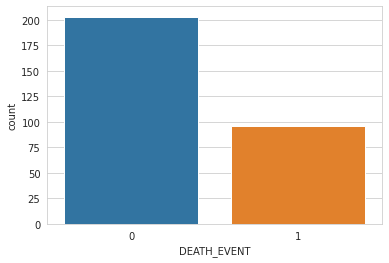

In [7]:
sns.countplot(x='DEATH_EVENT', data=df)
# znaczna przewaga obserwacji cenzuowanych (203), w stosunku do obesrwacji, w których obserwowany pacjent zmarł (96).
df['DEATH_EVENT'].value_counts()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Statystyka testu Jarque-Bera: 9.34, Wartość P-value: 0.009


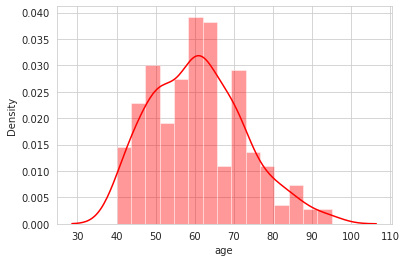

In [8]:
sns.distplot(df['age'], bins=15, color='red')
norm_test = stats.jarque_bera(df['age'])
print('Statystyka testu Jarque-Bera: {}, Wartość P-value: {}'.format(str(np.round(norm_test[0], 2)), str(np.round(norm_test[1], 3))))
# Należy odrzucić hipotezę zerową o normlaności rozkładu wieku pacjentów. Badani pacjenci są w wieku od 40 do 95, średnia wynosi 61, odchylenie standardowe 12, a mediana 60 lat

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


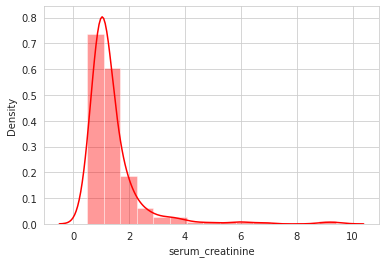

In [9]:
sns.distplot(df['serum_creatinine'], bins=15, color='red')

In [10]:
df['serum_creatinine'].describe()

count   299.000
mean      1.394
std       1.035
min       0.500
25%       0.900
50%       1.100
75%       1.400
max       9.400
Name: serum_creatinine, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


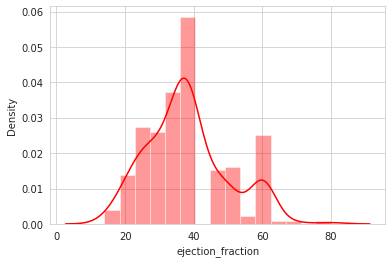

In [11]:
sns.distplot(df['ejection_fraction'], bins=15, color='red')

In [12]:
df['ejection_fraction'].describe()

count   299.000
mean     38.084
std      11.835
min      14.000
25%      30.000
50%      38.000
75%      45.000
max      80.000
Name: ejection_fraction, dtype: float64

1    194
0    105
Name: sex, dtype: int64

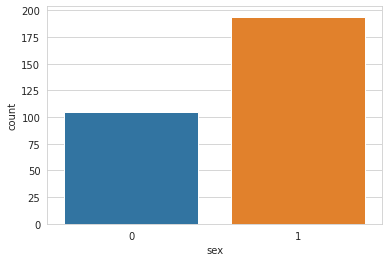

In [13]:
sns.countplot(x='sex', data=df)
df['sex'].value_counts()

In [14]:
df['sex'].describe()

count   299.000
mean      0.649
std       0.478
min       0.000
25%       0.000
50%       1.000
75%       1.000
max       1.000
Name: sex, dtype: float64

In [15]:
df.corr()['DEATH_EVENT'].sort_values(ascending=False)
# korelacja śmierci pacjenta wydaje się być najbardziej skorelowana z poziomem kreatyniny w surowicy we krwi, wiekiem, z frakcją wyrzutową - procentem krwi wyrzucanym przez serce przy każdym skurczu, a także samy czasem 
# obserwacji pacjenta
# DEATh_EVENT to zmienna binarna, a więc miara korelacji pearsona może nie być najlepsze, oraz korelacja nie oznacza przyczynowości

DEATH_EVENT                 1.000
serum_creatinine            0.294
age                         0.254
high_blood_pressure         0.079
anaemia                     0.066
creatinine_phosphokinase    0.063
diabetes                   -0.002
sex                        -0.004
smoking                    -0.013
platelets                  -0.049
serum_sodium               -0.195
ejection_fraction          -0.269
time                       -0.527
Name: DEATH_EVENT, dtype: float64

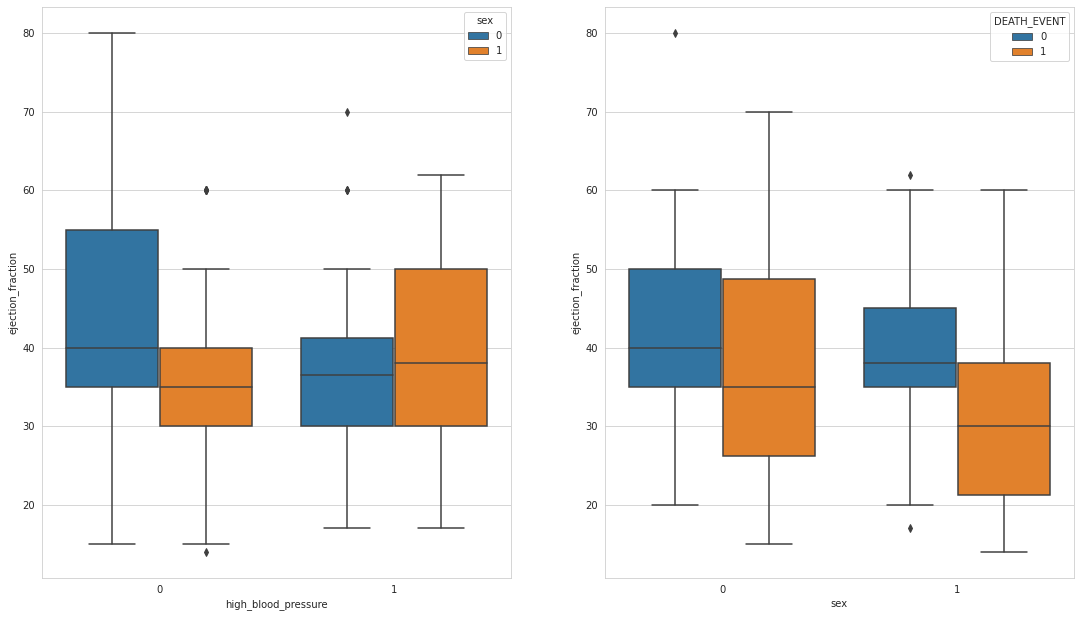

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)
sns.boxplot(y='ejection_fraction', x='high_blood_pressure', data=df, hue='sex', ax=ax1)
sns.boxplot(y='ejection_fraction', x='sex', data=df, hue='DEATH_EVENT', ax=ax2)

# Frakcja wyrzutowa wśród mężczyzn i kobiet ma podobną miedianę, jednak jest rozkład dla mężczyzn o niskim ciśnieniu krwi jest bardzo rozciągnięty, występuje znacznie więcej skrajnych obserwacji z bardzo wysokim wyrzutem frakcji
# zarówno mężczyźni jak i kobiety, które umarły, miały mniejszą miedianę frakcję wyrzutowej oraz bardziej rozciągnięty rozkład, z większą ilością obserwacji odstających zarówno z małyą frakcją wyrzutową jak i dużą 

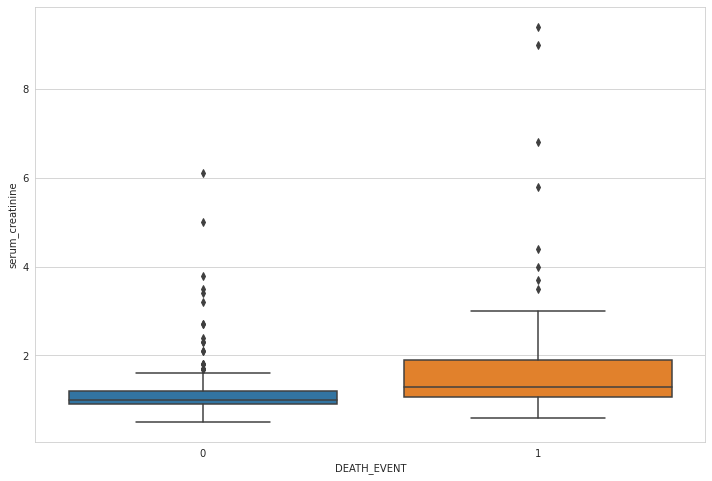

In [17]:


fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(12, 8)
sns.boxplot(y='serum_creatinine', x='DEATH_EVENT', data=df, ax=ax1)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count   96.000
mean    65.215
std     13.215
min     42.000
25%     55.000
50%     65.000
75%     75.000
max     95.000
Name: age, dtype: float64

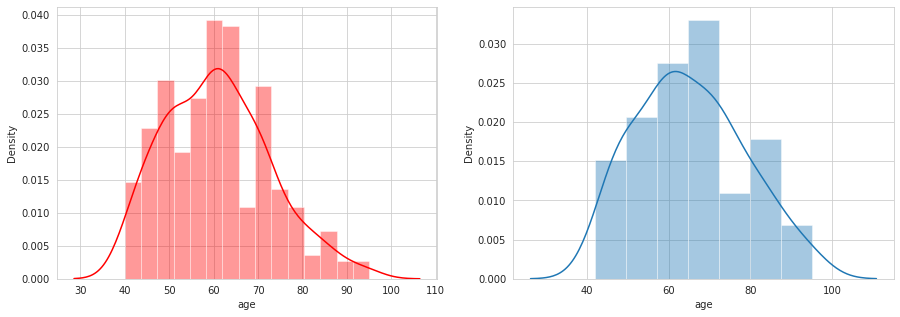

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
sns.distplot(df['age'], bins=15, color='red', ax=ax1)
sns.distplot(df['age'][df['DEATH_EVENT'] == 1], ax=ax2)

df['age'][df['DEATH_EVENT'] == 0].describe()
df['age'][df['DEATH_EVENT'] == 1].describe()

# pacjenci, którzy umierają mają średnio 65 lat (ze zbliżoną medianą) oraz odchyleniem standardowym 13,2 lat, podczas gdy pacjenci, którzy przeżywają w czasie trwania obserwacji
# mają średnio 58,7 lat (mediana 60) oz odchyleniem standardowym 10 lat. Wiek nie wydaje się silnym predyktorem, jednak zdaje się zmniejszać szansę na przeżycie do pewnego stopnia

In [19]:
table = survival_table_from_events(df['time'], df['DEATH_EVENT'])
table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.000,0,0,0,299,299
4.000,1,1,0,0,299
6.000,1,1,0,0,298
7.000,2,2,0,0,297
8.000,2,2,0,0,295
...,...,...,...,...,...
270.000,2,0,2,0,6
271.000,1,0,1,0,4
278.000,1,0,1,0,3


Text(0.5, 1.0, 'Krzywa Kaplana-Meiera (log-log)')

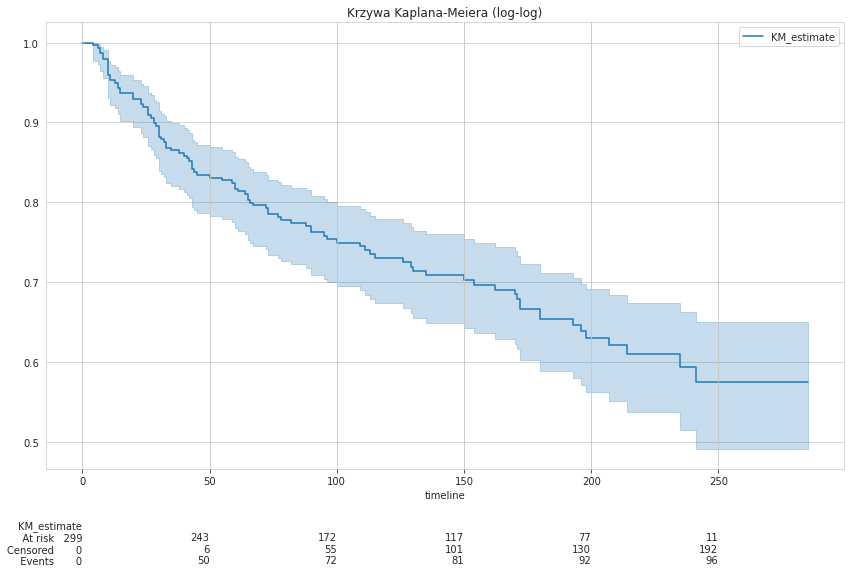

In [20]:
# estymator Kaplana-Meirea (confidence interval log-log)
km = KaplanMeierFitter(alpha=0.05)
km.fit(df['time'], event_observed=df['DEATH_EVENT'])

km.plot(at_risk_counts=True, figsize=(12,8))
plt.title('Krzywa Kaplana-Meiera (log-log)')

In [21]:
summary_km = pd.concat([table, km.survival_function_, km.confidence_interval_], axis=1)
summary_km.drop(['removed', 'entrance'], axis=1, inplace=True)
summary_km.columns = ['observed', 'censored', 'at_risk', 'survival', 'lower 95% CI', 'upper 95% CI']
summary_km


,observed,censored,at_risk,survival,lower 95% CI,upper 95% CI
0.000,0,0,299,1.000,1.000,1.000
4.000,1,0,299,0.997,0.976,1.000
6.000,1,0,298,0.993,0.974,0.998
7.000,2,0,297,0.987,0.965,0.995
8.000,2,0,295,0.980,0.956,0.991
...,...,...,...,...,...,...
270.000,0,2,6,0.576,0.492,0.651
271.000,0,1,4,0.576,0.492,0.651
278.000,0,1,3,0.576,0.492,0.651
280.000,0,1,2,0.576,0.492,0.651


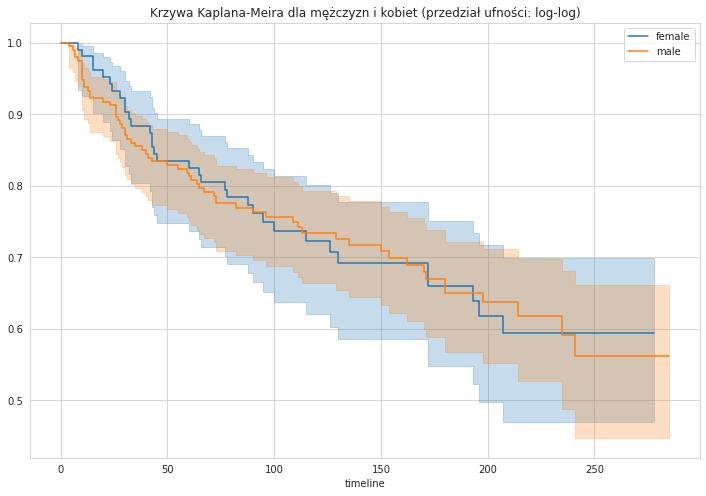

In [22]:
ax = plt.subplot(111)
km = KaplanMeierFitter()

km.fit(df['time'][df['sex'] == 0], event_observed=df['DEATH_EVENT'][df['sex'] == 0], label='female')
km.plot(figsize=(12,8), ax=ax)
plt.title('Krzywa Kaplana-Meira dla mężczyzn i kobiet (przedział ufności: log-log)')
km.fit(df['time'][df['sex'] == 1], event_observed=df['DEATH_EVENT'][df['sex'] == 1], label='male')
km.plot(figsize=(12,8), ax=ax)
plt.legend()

# krzywe trwania są bardzo zbliżone dla kobiet i mężczyzn

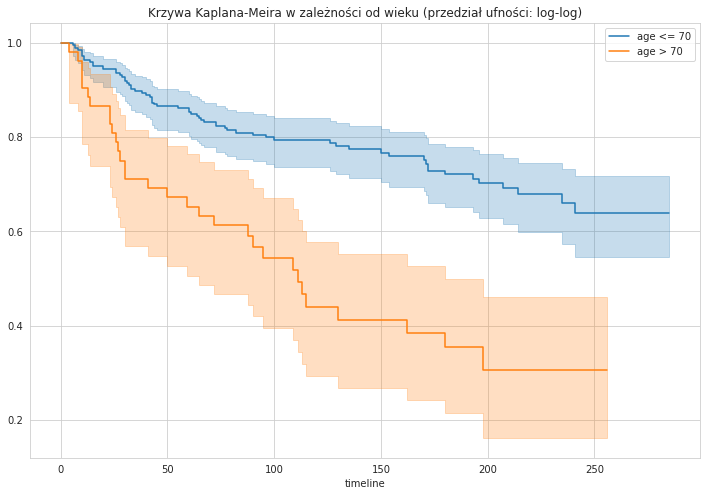

In [23]:
ax = plt.subplot(111)
km = KaplanMeierFitter()
x = 70
y = 'age'

km.fit(df['time'][df[y] <= x], event_observed=df['DEATH_EVENT'][df[y] <= x], label='{} <= {}'.format(y, x))
km.plot(figsize=(12,8), ax=ax)
plt.title('Krzywa Kaplana-Meira w zależności od wieku (przedział ufności: log-log)')
km.fit(df['time'][df[y] > x], event_observed=df['DEATH_EVENT'][df[y] > x], label='{} > {}'.format(y, x))
km.plot(figsize=(12,8), ax=ax)
plt.legend()

# prawdopobieństwo śmierci jest większe dla osób w wieku powyżej 60 lat (kyrzwa jest przesunięta w dół), dla rozróżnieia pacjentów pwyżej i poniżej 70 lat krzywa przesunięta jest znacznie mocniej (60 lat to miediana i średnia wieku obserwowanych pacjentów)

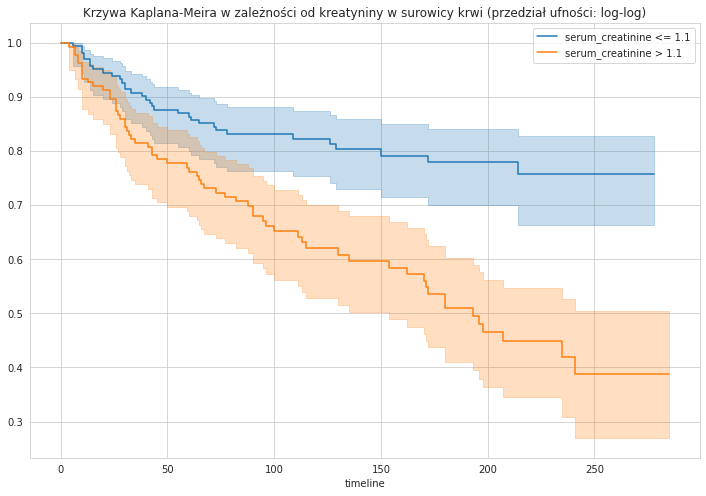

In [24]:
ax = plt.subplot(111)
km = KaplanMeierFitter()
x = 1.1
y = 'serum_creatinine'

km.fit(df['time'][df[y] <= x], event_observed=df['DEATH_EVENT'][df[y] <= x], label='{} <= {}'.format(y, x))
km.plot(figsize=(12,8), ax=ax)
plt.title('Krzywa Kaplana-Meira w zależności od kreatyniny w surowicy krwi (przedział ufności: log-log)')
km.fit(df['time'][df[y] > x], event_observed=df['DEATH_EVENT'][df[y] > x], label='{} > {}'.format(y, x))
km.plot(figsize=(12,8), ax=ax)
plt.legend()

# prawdopobieństwo śmierci jest znacznie większe dla pacjentów o  wyższym poziomie kreatyniny w surowicy krwi. Wybrany poziom różnicujący to 1.1 - wartość około mediany badanych pacjentów.

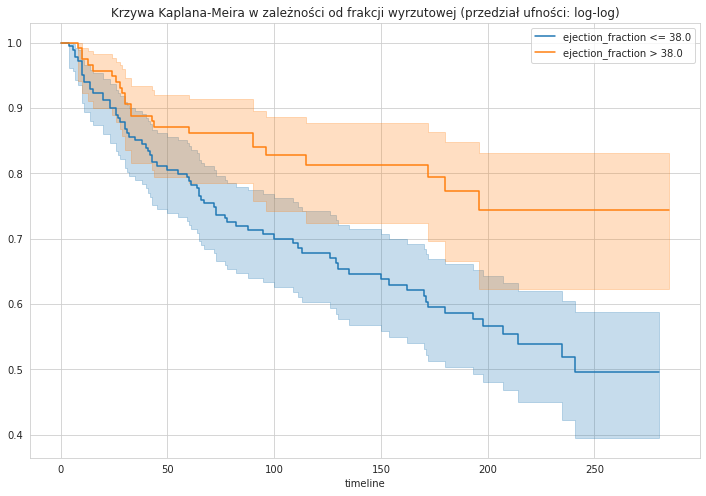

In [25]:
ax = plt.subplot(111)
km = KaplanMeierFitter()
x = df['ejection_fraction'].median()
y = 'ejection_fraction'

km.fit(df['time'][df[y] <= x], event_observed=df['DEATH_EVENT'][df[y] <= x], label='{} <= {}'.format(y, x))
km.plot(figsize=(12,8), ax=ax)
plt.title('Krzywa Kaplana-Meira w zależności od frakcji wyrzutowej (przedział ufności: log-log)')
km.fit(df['time'][df[y] > x], event_observed=df['DEATH_EVENT'][df[y] > x], label='{} > {}'.format(y, x))
km.plot(figsize=(12,8), ax=ax)
plt.legend()

# prawdopobieństwo śmierci jest znacznie większe dla pacjentów o niskim poziomie frakcji wyrzutowej. Wybrany poziom różnicujący to 1.1 - wartość około mediany badanych pacjentów.

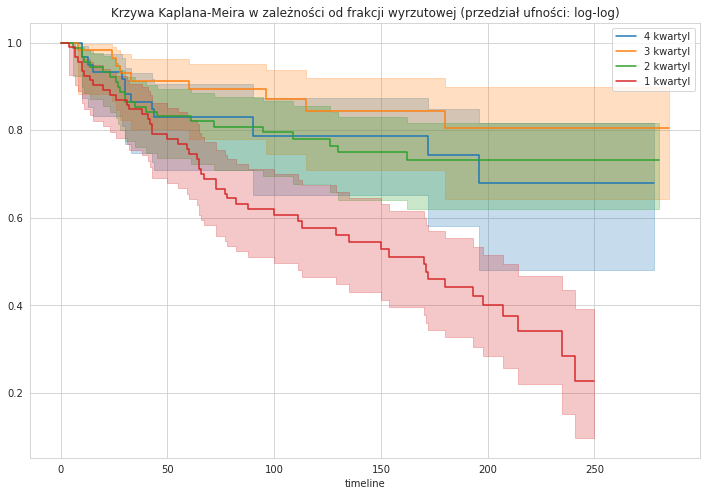

In [26]:
ax = plt.subplot(111)
km = KaplanMeierFitter()
df['pairwise'] = df['ejection_fraction'].apply(lambda x: '4 kwartyl' if x>45 else ('3 kwartyl' if x>38 else ('2 kwartyl' if x>30 else '1 kwartyl')))  
y = 'pairwise'

km.fit(df['time'][df[y] == '4 kwartyl'], event_observed=df['DEATH_EVENT'][df[y] == '4 kwartyl'], label='4 kwartyl'.format(y))
km.plot(figsize=(12,8), ax=ax)

plt.title('Krzywa Kaplana-Meira w zależności od frakcji wyrzutowej (przedział ufności: log-log)')

km.fit(df['time'][df[y] == '3 kwartyl'], event_observed=df['DEATH_EVENT'][df[y] == '3 kwartyl'], label='3 kwartyl'.format(y))
km.plot(figsize=(12,8), ax=ax)

km.fit(df['time'][df[y] == '2 kwartyl'], event_observed=df['DEATH_EVENT'][df[y] == '2 kwartyl'], label='2 kwartyl'.format(y))
km.plot(figsize=(12,8), ax=ax)

km.fit(df['time'][df[y] == '1 kwartyl'], event_observed=df['DEATH_EVENT'][df[y] == '1 kwartyl'], label='1 kwartyl'.format(y))
km.plot(figsize=(12,8), ax=ax)

plt.legend()

# prawdopobieństwo śmierci jest znacznie większe dla pacjentów o niskim poziomie frakcji wyrzutowej. Wybrany poziom różnicujący to 1.1 - wartość około mediany badanych pacjentów.

Text(0.5, 1.0, 'Krzywa Nelsona-Aalena (log-log)')

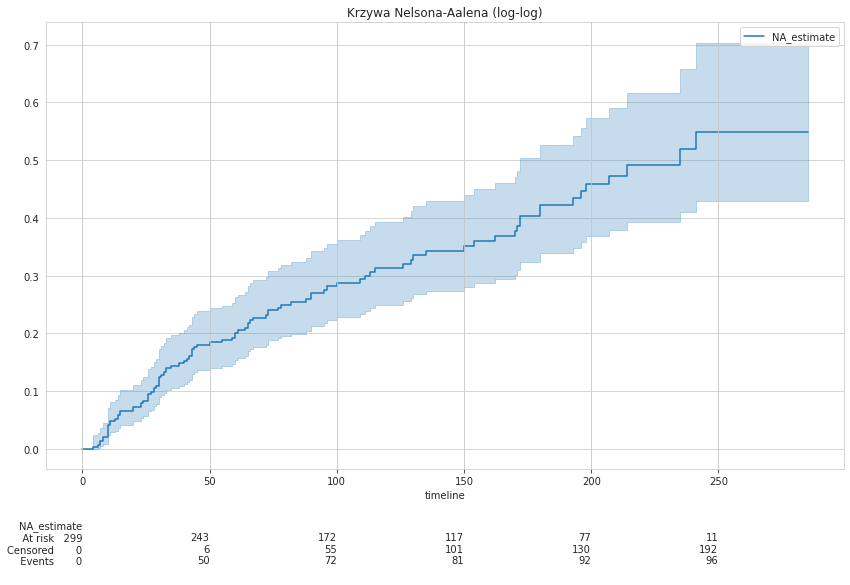

In [27]:
# estymator Nelsona-Aalena (confidence interval log-log)
nels = NelsonAalenFitter(0.05, False)
nels.fit(df['time'], event_observed=df['DEATH_EVENT'])

nels.plot(at_risk_counts=True, figsize=(12,8))
plt.title('Krzywa Nelsona-Aalena (log-log)')

In [28]:
summary_na = pd.concat([table, nels.cumulative_hazard_, nels.confidence_interval_], axis=1)
summary_na.drop(['removed', 'entrance'], axis=1, inplace=True)
summary_na.columns = ['observed', 'censored', 'at_risk', 'hazard', 'lower 95% CI', 'upper 95% CI']
summary_na['survival'] = np.exp(-summary_na['hazard'])
summary_na

,observed,censored,at_risk,hazard,lower 95% CI,upper 95% CI,survival
0.000,0,0,299,0.000,0.000,0.000,1.000
4.000,1,0,299,0.003,0.000,0.024,0.997
6.000,1,0,298,0.007,0.002,0.027,0.993
7.000,2,0,297,0.013,0.005,0.036,0.987
8.000,2,0,295,0.020,0.009,0.045,0.980
...,...,...,...,...,...,...,...
270.000,0,2,6,0.549,0.428,0.703,0.578
271.000,0,1,4,0.549,0.428,0.703,0.578
278.000,0,1,3,0.549,0.428,0.703,0.578
280.000,0,1,2,0.549,0.428,0.703,0.578


Text(0, 0.5, 'Funkcja trwania')

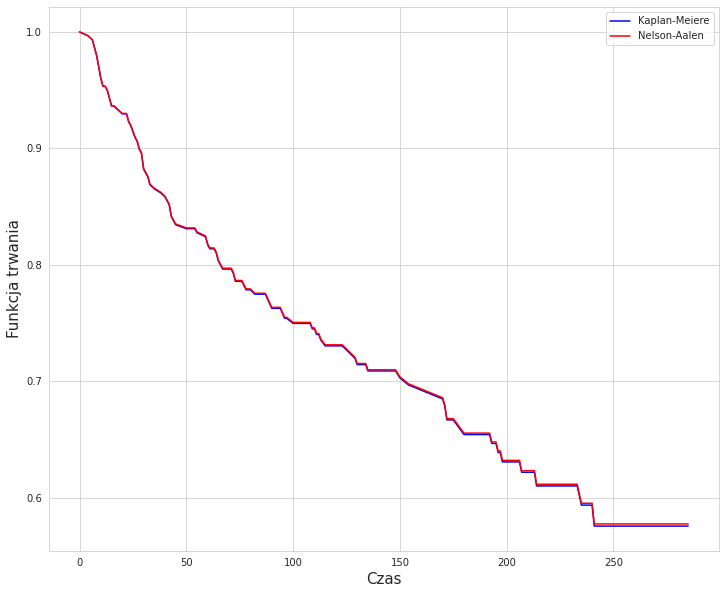

In [29]:
plt.figure(figsize=(12,10))
plt.plot(summary_km['survival'], c='blue', label='Kaplan-Meiere')
plt.plot(summary_na['survival'], c='red', label='Nelson-Aalen')
plt.legend()
plt.xlabel('Czas', fontsize=15)
plt.ylabel('Funkcja trwania', fontsize=15)

In [30]:
a = summary_na['survival'] - summary_km['survival']
print(a)
print(np.max(a))
print(np.max(a) / summary_km['survival'].min()*100)

0.000     0.000
4.000     0.000
6.000     0.000
7.000     0.000
8.000     0.000
           ... 
270.000   0.002
271.000   0.002
278.000   0.002
280.000   0.002
285.000   0.002
Name: survival, Length: 149, dtype: float64
0.00184825405727862
0.321042023082176


In [31]:
# Test logrank

test_logrank = logrank_test(
    df['time'][df['sex'] == 0], df['time'][df['sex'] == 1],
    df['DEATH_EVENT'][df['sex'] == 0], df['DEATH_EVENT'][df['sex'] == 1])

test_logrank2 = logrank_test(
    df['time'][df['age'] > 70], df['time'][df['age'] <= 70],
    df['DEATH_EVENT'][df['age'] > 70], df['DEATH_EVENT'][df['age'] <= 70],
    weightings='fleming-harrington', p=1, q=0)

test_petopeto = logrank_test(
    df['time'][df['serum_creatinine'] > 1.1], df['time'][df['serum_creatinine'] <= 1.1],
    df['DEATH_EVENT'][df['serum_creatinine'] > 1.1], df['DEATH_EVENT'][df['serum_creatinine'] <= 1.1],
    weightings='fleming-harrington', p=1, q=1)

test_petopeto2 = logrank_test(
    df['time'][df['ejection_fraction'] > 38], df['time'][df['ejection_fraction'] <= 38],
    df['DEATH_EVENT'][df['ejection_fraction'] > 38], df['DEATH_EVENT'][df['ejection_fraction'] <= 38],
    weightings='fleming-harrington', p=1, q=1)



test_pairwise = pairwise_logrank_test(df['time'], df['pairwise'], df['DEATH_EVENT'],
                                      weightings='fleming-harrington', p=1, q=1)

test_logrank.print_summary()
print('\n')
test_logrank2.print_summary()
print('\n')
test_petopeto.print_summary()
print('\n')
test_petopeto2.print_summary()
print('\n')
test_pairwise.print_summary()
print('\n')

# logrank equal weights, najpopularniejszy
# większe wagi na początku czasu preżycia, mniejsze na końcu


# brak podstaw do odrzuecania H0, ktora mowi o tym ze krzywe trwania się nie różnią (płeć)
# krzywe różnią się ze względu na wiek (gdzie jest podział na 2 grupy -> więcej niż 60 lat, lub równo i mniej niż 60 lat)
# krzywe różnią się ze względu na poziom kreatyniny w surowicy krwi (gdzie jest podział na 2 grupy -> więcej niż 1.1 mg/dl, lub równo i mniej niż 1.1 mg/dl)
# krzywe różnią się ze względu na poziom frakcji wyrzutu (gdzie jest podział na 2 grupy -> więcej niż 38%, lub równo i mniej niż 38%)
# przy sprawdzaniu parami testem logrank, statystycznie istotna różnica pomiędzy rozkładami jest widoczna jedynie pomiędzy grupą gdzie frakja wyrzutowa pomiędzy miedianą i 3 kwartylem, a grupą poniżej mediany. Wskazuje to na to, ze zarówno zbyt wysoki jak i zbyt niski współczynnik frakji wyrzutu
# wpyłwa negatywnie na szansę przeżycia pacjenta

# po obejrzeniu dodac / zmienic rodzaje testow, dodac fleming harrington test

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.00 0.95      0.07

<lifelines.StatisticalResult: Flemington-Harrington_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
                 p = 1
                 q = 0
         test_name = Flemington-Harrington_test

---
 test_statistic      p  -log2(p)
          26.70 <0.005     22.00

<lifelines.StatisticalResult: Flemington-Harrington_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
                 p = 1
                 q = 1
         test_name = Flemington-Harrington_test

---
 test_statistic      p  -log2(p)
          23.10 <0.005     19.31

<lifelines.StatisticalResult: Flemington-Harrington_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
                 p = 1
                 q = 1
         test_name = Flemington-Harrington_test

---
 test_statistic      p  -log2(p)
           8.79 <0.005      8.36

<lifelines.StatisticalResult: Flemington-Harrington_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
                 p = 1
                 q = 1
         test_name = Flemington-Harrington_test

---
                     test_statistic      p  -log2(p)
1 kwartyl 2 kwartyl           24.29 <0.005     20.20
          3 kwartyl           18.88 <0.005     16.13
          4 kwartyl           10.35 <0.005      9.60
2 kwartyl 3 kwartyl            0.52   0.47      1.08
          4 kwartyl            0.16   0.69      0.53
3 kwartyl 4 kwartyl            1.00   0.32      1.65

In [32]:
##### model PH Cox
df = df.drop('pairwise', axis=1)
model = CoxPHFitter()
model.fit(df, duration_col='time', event_col='DEATH_EVENT')
model.print_summary()

# należy odrzucić wszystkie statystycznie nieistotne zmienne (dla alfa 0,05)
# warto zauważyć, że badane przez nas wcześniej zmienne serotniona i frakcja mają najmniejsz pvalue oraz najwyższą statystykę testową, skolei zmienna płeć (sex) jest nieistotna - co potwierdza poprawność wcześniejszych analiz

<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
             duration col = 'time'
                event col = 'DEATH_EVENT'
      baseline estimation = breslow
   number of observations = 299
number of events observed = 96
   partial log-likelihood = -468.23
         time fit was run = 2021-01-27 18:01:33 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
age                        0.05       1.05       0.01             0.03             0.06                 1.03                 1.07
anaemia                    0.46       1.58       0.22             0.04             0.89                 1.04                 2.42
creatinine_phosphokinase   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
diabetes                   0.14       1.15       0.22            -0.30             0.58                 0.74                 1.78
ejection_fraction         -0.05       0.95       0.01            -0.07            -0.03                 0.93                 0.97
high_blood_pressure        0.48       1.61       0.22             0.05             0.90                 1.05                 2.46
platelets                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
serum_creatinine           0.32       1.38       0.07             0.18             0.46                 1.20                 1.58
serum_sodium              -0.04       0.96       0.02            -0.09             0.00                 0.91                 1.00
sex                       -0.24       0.79       0.25            -0.73             0.26                 0.48                 1.29
smoking                    0.13       1.14       0.25            -0.36             0.62                 0.70                 1.86

                             z      p   -log2(p)
covariate                                       
age                       4.98 <0.005      20.56
anaemia                   2.12   0.03       4.89
creatinine_phosphokinase  2.23   0.03       5.26
diabetes                  0.63   0.53       0.91
ejection_fraction        -4.67 <0.005      18.35
high_blood_pressure       2.20   0.03       5.17
platelets                -0.41   0.68       0.56
serum_creatinine          4.58 <0.005      17.68
serum_sodium             -1.90   0.06       4.12
sex                      -0.94   0.35       1.53
smoking                   0.51   0.61       0.72
---
Concordance = 0.74
Partial AIC = 958.46
log-likelihood ratio test = 81.95 on 11 df
-log2(p) of ll-ratio test = 40.56

In [33]:
df = df.drop(['diabetes', 'platelets', 'sex', 'smoking'], axis=1)
model2 = CoxPHFitter()
model2.fit(df, duration_col='time', event_col='DEATH_EVENT')
model2.print_summary(decimals=3)
# zmienna anaemia jest teraz również nieistotna oraz zmienna creatinine_phosphokinase stała się nieistotna później - jednak wyrzucenie ich zwiększało poziom kryterium informacyjnego AIC

<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
             duration col = 'time'
                event col = 'DEATH_EVENT'
      baseline estimation = breslow
   number of observations = 299
number of events observed = 96
   partial log-likelihood = -468.914
         time fit was run = 2021-01-27 18:01:34 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
age                       0.044      1.045      0.009            0.026            0.061                1.027                1.063
anaemia                   0.446      1.562      0.215            0.025            0.867                1.025                2.381
creatinine_phosphokinase  0.000      1.000      0.000            0.000            0.000                1.000                1.000
ejection_fraction        -0.047      0.954      0.010           -0.068           -0.027                0.935                0.973
high_blood_pressure       0.497      1.643      0.214            0.078            0.915                1.081                2.498
serum_creatinine          0.314      1.369      0.069            0.179            0.449                1.196                1.567
serum_sodium             -0.046      0.955      0.023           -0.091            0.000                0.913                1.000

                              z       p   -log2(p)
covariate                                         
age                       4.934 <0.0005     20.244
anaemia                   2.075   0.038      4.717
creatinine_phosphokinase  2.138   0.033      4.943
ejection_fraction        -4.621 <0.0005     17.996
high_blood_pressure       2.324   0.020      5.633
serum_creatinine          4.552 <0.0005     17.524
serum_sodium             -1.956   0.050      4.309
---
Concordance = 0.738
Partial AIC = 951.828
log-likelihood ratio test = 80.583 on 7 df
-log2(p) of ll-ratio test = 46.440

In [34]:
df2 = df.drop(['anaemia', 'creatinine_phosphokinase'], axis=1)
model3 = CoxPHFitter()
model3.fit(df2, duration_col='time', event_col='DEATH_EVENT')
model3.print_summary()

<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
             duration col = 'time'
                event col = 'DEATH_EVENT'
      baseline estimation = breslow
   number of observations = 299
number of events observed = 96
   partial log-likelihood = -472.33
         time fit was run = 2021-01-27 18:01:34 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
age                   0.04       1.05       0.01             0.03             0.06                 1.03                 1.06
ejection_fraction    -0.05       0.96       0.01            -0.07            -0.03                 0.94                 0.97
high_blood_pressure   0.49       1.64       0.21             0.08             0.91                 1.08                 2.48
serum_creatinine      0.32       1.37       0.07             0.18             0.45                 1.19                 1.58
serum_sodium         -0.04       0.96       0.02            -0.08             0.01                 0.92                 1.01

                        z      p   -log2(p)
covariate                                  
age                  4.95 <0.005      20.36
ejection_fraction   -4.47 <0.005      16.96
high_blood_pressure  2.33   0.02       5.67
serum_creatinine     4.48 <0.005      17.05
serum_sodium        -1.61   0.11       3.21
---
Concordance = 0.73
Partial AIC = 954.66
log-likelihood ratio test = 73.75 on 5 df
-log2(p) of ll-ratio test = 45.75

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
         test_name = proportional_hazard_test

---
                               test_statistic    p  -log2(p)
age                      km              0.06 0.81      0.31
                         rank            0.02 0.89      0.18
anaemia                  km              0.01 0.93      0.11
                         rank            0.00 0.99      0.02
creatinine_phosphokinase km              0.91 0.34      1.56
                         rank            0.87 0.35      1.51
ejection_fraction        km              5.33 0.02      5.58
                         rank            5.57 0.02      5.78
high_blood_pressure      km              0.07 0.79      0.34
                         rank            0.05 0.82      0.29
serum_creatinine         km              3.67 0.06      4.17
                         rank            3.73 0.05      4.23
serum_sodium             km              1.21 0.27      1.88
                         rank            1.89 0.17      2.56



1. Variable 'ejection_fraction' failed the non-proportional test: p-value is 0.0182.

   Advice 1: the functional form of the variable 'ejection_fraction' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'ejection_fraction' using pd.cut, and then specify it in
`strata=['ejection_fraction', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'serum_creatinine' failed the non-proportional test: p-value is 0.0534.

   Advice 1: the functional form of the variable 'serum_creatinine' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very s

[[<matplotlib.axes._subplots.AxesSubplot at 0x7f29c59cd9b0>,

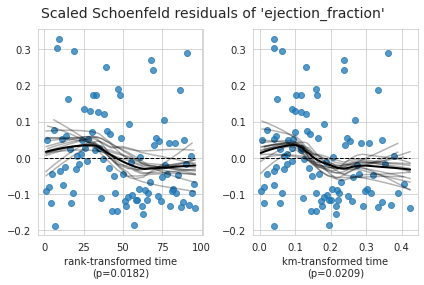

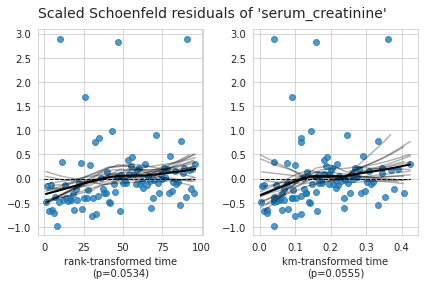

In [35]:
### model 2 jest tutaj najlepszy (AIC, -log2(p))

# czym jest założenie proporcjonalności hazardu

model2.check_assumptions(df, p_value_threshold=0.05, show_plots=True)

# 2 zmienne, które jak dotąd wydają się najlepszymi predyktorami hazardu, zostały odrzucone przez ten na założenie proporcjonalności hazardu.
# może tak być ponieważ nie są one liniowo związane z funkcją hazardu - co jest bardzo praodopobne ze względu na opisane wcześniej zwiększenie prawdopodobieństwa śmierci pacjenta zarówno gdy frakcja wyrzutowa była za wysoka jak i za niska
# w tym celu te 2 zmienne zostaną podzielone na 4 części, tak aby wpływ w zależności od poziomu był modelowany osobno (i w miarę możliwości był liniowy)

In [36]:
model2.fit(df, 'time', 'DEATH_EVENT', formula='age + anaemia + creatinine_phosphokinase + bs(ejection_fraction, df=3, lower_bound=14, upper_bound=80) +  high_blood_pressure + bs(serum_creatinine, df=3, lower_bound=0.5, upper_bound=9.4) + serum_sodium')
model2.print_summary(decimals=3, model='spline model')

<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
             duration col = 'time'
                event col = 'DEATH_EVENT'
      baseline estimation = breslow
   number of observations = 299
number of events observed = 96
   partial log-likelihood = -458.475
         time fit was run = 2021-01-27 18:01:36 UTC
                    model = spline model

---
                                                                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                               
age                                                              0.041      1.042      0.009            0.023            0.059                1.023                1.061
anaemia                                                          0.576      1.779      0.223            0.139            1.014                1.149                2.756
bs(ejection_fraction, df=3, lower_bound=14, upper_bound=80)[1]  -6.252      0.002      1.797           -9.773           -2.731                0.000                0.065
bs(ejection_fraction, df=3, lower_bound=14, upper_bound=80)[2]   0.649      1.914      2.092           -3.451            4.750                0.032              115.530
bs(ejection_fraction, df=3, lower_bound=14, upper_bound=80)[3]  -5.728      0.003      2.877          -11.367           -0.089                0.000                0.915
bs(serum_creatinine, df=3, lower_bound=0.5, upper_bound=9.4)[1]  5.227    186.305      1.603            2.086            8.369                8.051             4311.212
bs(serum_creatinine, df=3, lower_bound=0.5, upper_bound=9.4)[2] -2.455      0.086      1.981           -6.337            1.428                0.002                4.169
bs(serum_creatinine, df=3, lower_bound=0.5, upper_bound=9.4)[3]  3.843     46.647      1.061            1.763            5.922                5.833              373.061
creatinine_phosphokinase                                         0.000      1.000      0.000            0.000            0.001                1.000                1.001
high_blood_pressure                                              0.439      1.550      0.221            0.006            0.871                1.006                2.390
serum_sodium                                                    -0.031      0.969      0.024           -0.078            0.016                0.925                1.016

                                                                     z       p   -log2(p)
covariate                                                                                
age                                                              4.464 <0.0005     16.926
anaemia                                                          2.581   0.010      6.664
bs(ejection_fraction, df=3, lower_bound=14, upper_bound=80)[1]  -3.480   0.001     10.961
bs(ejection_fraction, df=3, lower_bound=14, upper_bound=80)[2]   0.310   0.756      0.403
bs(ejection_fraction, df=3, lower_bound=14, upper_bound=80)[3]  -1.991   0.046      4.427
bs(serum_creatinine, df=3, lower_bound=0.5, upper_bound=9.4)[1]  3.261   0.001      9.816
bs(serum_creatinine, df=3, lower_bound=0.5, upper_bound=9.4)[2] -1.239   0.215      2.216
bs(serum_creatinine, df=3, lower_bound=0.5, upper_bound=9.4)[3]  3.622 <0.0005     11.742
creatinine_phosphokinase                                         3.135   0.002      9.185
high_blood_pressure                                              1.986   0.047      4.410
serum_sodium                                                    -1.304   0.192      2.378
---
Concordance = 0.765
Partial AIC = 938.951
log-likelihood ratio test = 101.460 on 11 df
-log2(p) of ll-ratio test = 53.275

In [37]:
model2.check_assumptions(df, show_plots=True, p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

In [38]:
rest = model2.compute_residuals(df, kind='schoenfeld')
rest2 = model2.compute_residuals(df, kind='scaled_schoenfeld')
rest
#  kind must be in {'delta_beta', 'martingale', 'schoenfeld', 'deviance', 'score', 'scaled_schoenfeld'}

covariate,age,anaemia,"bs(ejection_fraction, df=3, lower_bound=14, upper_bound=80)[1]","bs(ejection_fraction, df=3, lower_bound=14, upper_bound=80)[2]","bs(ejection_fraction, df=3, lower_bound=14, upper_bound=80)[3]","bs(serum_creatinine, df=3, lower_bound=0.5, upper_bound=9.4)[1]","bs(serum_creatinine, df=3, lower_bound=0.5, upper_bound=9.4)[2]","bs(serum_creatinine, df=3, lower_bound=0.5, upper_bound=9.4)[3]",creatinine_phosphokinase,high_blood_pressure,serum_sodium
0,6.164,-0.592,-0.101,-0.140,-0.050,0.093,-0.002,-0.105,-52.458,0.492,-4.206
1,-13.683,-0.607,0.113,0.086,-0.004,-0.064,-0.052,-0.112,7225.242,-0.495,1.689
2,-3.811,-0.611,-0.103,-0.144,-0.051,-0.017,-0.043,-0.112,-444.383,-0.500,-5.303
3,-18.811,0.389,-0.103,-0.144,-0.051,0.095,-0.003,-0.109,-479.383,-0.500,2.697
4,-3.873,0.393,-0.104,-0.146,-0.052,0.182,0.073,-0.100,-441.208,-0.507,-18.487
...,...,...,...,...,...,...,...,...,...,...,...
220,10.061,-0.340,-0.140,-0.164,-0.050,0.091,0.013,-0.003,-2.740,-0.187,-1.618
230,-1.987,-0.357,0.030,-0.070,-0.037,0.076,0.001,-0.005,-374.671,-0.204,-9.024
246,-4.938,-0.317,-0.035,-0.122,-0.043,-0.053,-0.026,-0.003,1375.689,-0.148,1.792
262,4.515,0.653,-0.035,-0.125,-0.042,0.010,-0.012,-0.003,-437.647,-0.062,-7.161


In [39]:
rest.mean()

covariate
age                                                                0.000
anaemia                                                           -0.000
bs(ejection_fraction, df=3, lower_bound=14, upper_bound=80)[1]     0.000
bs(ejection_fraction, df=3, lower_bound=14, upper_bound=80)[2]    -0.000
bs(ejection_fraction, df=3, lower_bound=14, upper_bound=80)[3]    -0.000
bs(serum_creatinine, df=3, lower_bound=0.5, upper_bound=9.4)[1]    0.000
bs(serum_creatinine, df=3, lower_bound=0.5, upper_bound=9.4)[2]   -0.000
bs(serum_creatinine, df=3, lower_bound=0.5, upper_bound=9.4)[3]   -0.000
creatinine_phosphokinase                                           0.000
high_blood_pressure                                               -0.000
serum_sodium                                                      -0.000
dtype: float64

In [40]:
np.mean(model2.baseline_hazard_)

baseline hazard   0.003
dtype: float64